# Robust Sovereignty Strategy (Ultra-CFO)
## Dynamic Programming + CVaR + Wasserstein (DRO) + time-varying ε(t)

This notebook provides a **board/CFO-ready toy model** for supplier dependency risk under:
- **Tariff shock** (e.g., +100% cost) and unilateral pricing power
- **Exit constraint**: needs **3 years** of progress (lock-in / migration)
- **CAPEX (one-off)** vs **OPEX (recurring)**
- **Exercise cost** (termination fee + cutover + recert/audit)
- **Ambiguity** on transition probabilities via a **Wasserstein ball** of radius $\varepsilon(t)$
- Objective: **worst-case CVaR** of **NPV cash** (or EBITDA)

Outputs:
- Baseline vs $\varepsilon(t)$ scenario
- **Sovereignty premium** = $V_0(\varepsilon(t)) - V_0(0)$ (worst-case NPV drop when adding ambiguity)
- Slide-like plots

In [61]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import time
from itertools import product
from tqdm.auto import tqdm
from pydantic import BaseModel, Field, field_validator, ConfigDict


np.set_printoptions(precision=3, suppress=True)

## 1) Model spec

We model the firm as a **single strategic decision-maker** against **Nature** (political/regulatory environment).
State includes:
- tariff regime: $\mathrm{tariff} \in \{0,1\}$
- migration progress: $m \in \{0,\ldots,3\}$
- flags for CAPEX already paid (invest, hedge setup)
- exit exercised or not

This keeps the model Markovian and DP-solvable.

In [62]:
PlayerId = int
Action = int
State = int

# Action indices (keep explicit; policy arrays store these ints)
WAIT = 0
INVEST = 1
HEDGE_ONLY = 2
ACCELERATE_MIGRATION = 3
INVEST_HEDGE_EXERCISE = 4

class CFOConfig(BaseModel):
    wacc: float = Field(default=0.10, ge=0.0, le=0.5)          # discount rate
    amort_years: int = Field(default=5, ge=1, le=15)           # for reporting (toy)
    tax_rate: float = Field(default=0.25, ge=0.0, le=0.6)      # optional
    objective: str = Field(default="cash_npv", pattern="^(cash_npv|ebitda_npv)$")

class GameSpec(BaseModel):
    # horizon / actions
    horizon: int = 10
    exit_years: int = 3
    actions_per_player: int = 5  # 0=wait, 1=invest, 2=hedge_only, 3=accelerate_migration, 4=invest+hedge/exercise-if-ready

    # risk
    alpha_cvar: float = 0.9

    # tariff / dependency
    tariff_cost: float = 10.0
    hedged_tariff_cost: float = 6.0
    post_exit_cost: float = 1.0

    # Nominal tariff Markov chain (parameterized for sensitivity)
    tariff_p01: float = 0.15  # P(tariff:0->1)
    tariff_p10: float = 0.10  # P(tariff:1->0)

    # CAPEX cash one-off
    capex_invest: float = 8.0
    capex_hedge_setup: float = 2.0

    # OPEX cash recurring
    opex_migration: float = 1.5
    opex_dual_run: float = 0.7

    # Accelerated migration
    accelerate_step: int = 2                 # m += 2 when accelerating
    opex_accelerate_extra: float = 1.5       # extra OPEX per period when accelerating (in addition to opex_migration)

    # exercise costs (cash one-off)
    termination_fee: float = 12.0
    cutover_cost: float = 5.0
    recert_audit_cost: float = 2.0

    cfo: CFOConfig = CFOConfig()

class JointAction(BaseModel):
    actions: tuple[Action, ...]

    @field_validator("actions")
    @classmethod
    def non_empty(cls, v):
        if len(v) == 0:
            raise ValueError("Empty joint action")
        return v

## 2) State encoding

State dimensions:
- $\mathrm{tariff} \in \{0,1\}$, $m \in \{0,\ldots,3\}$, $\mathrm{inv},\mathrm{hed},\mathrm{ex} \in \{0,1\}$

Total number of states: $|\mathcal{S}| = 2 \times 4 \times 2 \times 2 \times 2 = 64$.

In [63]:
def encode_state(tariff: int, m: int, inv: int, hed: int, ex: int) -> int:
    return (((tariff * 4 + m) * 2 + inv) * 2 + hed) * 2 + ex

def decode_state(s: int):
    ex = s % 2; s //= 2
    hed = s % 2; s //= 2
    inv = s % 2; s //= 2
    m = s % 4;   s //= 4
    tariff = s
    return tariff, m, inv, hed, ex

N_STATES = 2 * 4 * 2 * 2 * 2  # 64

## 3) Wasserstein transport cost

We model ambiguity via a **Wasserstein ball** around the nominal transition: distributions $p$ with $W_C(p, p_0) \leq \varepsilon$, where $C_{ij}$ is the cost of moving mass from state $i$ to state $j$.

We want ambiguity mainly on **tariff dynamics** (political). We penalize moving probability mass across internal flags $(m, \mathrm{inv}, \mathrm{hed}, \mathrm{ex})$ heavily in $C$.

In [64]:
def transport_cost_matrix():
    C = np.zeros((N_STATES, N_STATES))
    for i in range(N_STATES):
        ti, mi, invi, hedi, exi = decode_state(i)
        for j in range(N_STATES):
            tj, mj, invj, hedj, exj = decode_state(j)

            c_tar = 1.0 * abs(ti - tj)          # cheap to move across tariff
            c_m   = 10.0 * abs(mi - mj)         # expensive to move across progress
            c_inv = 50.0 * abs(invi - invj)     # very expensive across flags
            c_hed = 50.0 * abs(hedi - hedj)
            c_ex  = 50.0 * abs(exi - exj)

            C[i, j] = c_tar + c_m + c_inv + c_hed + c_ex
    return C

## 4) Nominal transition and time constraint

- **Tariff**: nominal 2-state Markov chain $P(\mathrm{tariff}_{t+1} \mid \mathrm{tariff}_t)$ with $p_{01}$, $p_{10}$.
- **Progress** $m$ increases each period depending on action (e.g. +1 for invest/hedge, +2 for accelerate), capped at $\mathrm{exit\_years}$.
- **Exit** is exercised when the invest+hedge/exercise action is chosen and $m$ has reached $\mathrm{exit\_years}$.

In [65]:
def nominal_tariff_transition(spec: GameSpec, tariff: int) -> np.ndarray:
    # Parameterized nominal dynamics; can be stressed/calibrated.
    p01 = float(spec.tariff_p01)
    p10 = float(spec.tariff_p10)
    if tariff == 0:
        return np.array([1.0 - p01, p01])
    return np.array([p10, 1.0 - p10])


def progress_increment(spec: GameSpec, action: int) -> int:
    if action in (INVEST, INVEST_HEDGE_EXERCISE):
        return 1
    if action == ACCELERATE_MIGRATION:
        return int(spec.accelerate_step)
    return 0


def next_progress(spec: GameSpec, m: int, action: int) -> int:
    inc = progress_increment(spec, action)
    return min(spec.exit_years, m + inc)


def build_p0_over_full_state(spec: GameSpec, s: int, action: int) -> np.ndarray:
    tariff, m, inv, hed, ex = decode_state(s)

    # absorbing after exit
    if ex == 1:
        m_next, inv_next, hed_next, ex_next = spec.exit_years, inv, hed, 1
    else:
        m_next = next_progress(spec, m, action)

        inv_next = inv or (1 if action in (INVEST, ACCELERATE_MIGRATION, INVEST_HEDGE_EXERCISE) else 0)
        hed_next = hed or (1 if action in (HEDGE_ONLY, INVEST_HEDGE_EXERCISE) else 0)

        # exercise is only triggered by the invest+hedge/exercise action once progress is complete
        ex_next = 1 if (action == INVEST_HEDGE_EXERCISE and m_next == spec.exit_years) else 0

    p_tar = nominal_tariff_transition(spec, tariff)
    p0 = np.zeros(N_STATES)

    for tariff_next in (0, 1):
        s_next = encode_state(tariff_next, m_next, int(inv_next), int(hed_next), int(ex_next))
        p0[s_next] += p_tar[tariff_next]

    return p0

## 5) Cash vs EBITDA mapping (CFO)

We compute:
- **Cash** flow: CAPEX + OPEX + tariff cost + exercise cost (one-off).
- **EBITDA** (toy): OPEX + tariff (exercise treated as exceptional).

Objective (discounted at WACC $r$):
- `cash_npv`: worst-case CVaR of $\sum_t \gamma_t \cdot \mathrm{cash}_t$ with $\gamma_t = (1+r)^{-t}$.
- `ebitda_npv`: same on EBITDA proxy.

In [66]:
def discount_factor(spec: GameSpec, t: int) -> float:
    r = spec.cfo.wacc
    return 1.0 / ((1.0 + r) ** t)


def stage_losses_cfo(spec: GameSpec, s: int, action: int):
    tariff, m, inv, hed, ex = decode_state(s)

    # CAPEX cash one-off
    capex_cash = 0.0
    if inv == 0 and action in (INVEST, ACCELERATE_MIGRATION, INVEST_HEDGE_EXERCISE):
        capex_cash += spec.capex_invest
    if hed == 0 and action in (HEDGE_ONLY, INVEST_HEDGE_EXERCISE):
        capex_cash += spec.capex_hedge_setup

    # OPEX recurring while migrating and investment started
    invest_started = (inv == 1) or (action in (INVEST, ACCELERATE_MIGRATION, INVEST_HEDGE_EXERCISE))
    opex_cash = 0.0
    if ex == 0 and invest_started and m < spec.exit_years:
        opex_cash += spec.opex_migration
        if action == ACCELERATE_MIGRATION:
            opex_cash += spec.opex_accelerate_extra
        if tariff == 1:
            opex_cash += spec.opex_dual_run

    # Exercise costs
    exercise_cash = 0.0
    m_next = next_progress(spec, m, action)
    will_exercise = (ex == 0 and action == INVEST_HEDGE_EXERCISE and m_next == spec.exit_years)
    if will_exercise:
        exercise_cash += spec.termination_fee + spec.cutover_cost + spec.recert_audit_cost

    # Tariff cash cost
    tariff_cash = 0.0
    if tariff == 1:
        if ex == 1:
            tariff_cash = spec.post_exit_cost
        else:
            # Hedge is effective if already set up OR if we choose a hedge action now.
            hed_effective = (hed == 1) or (action in (HEDGE_ONLY, INVEST_HEDGE_EXERCISE))
            if m < spec.exit_years:
                tariff_cash = spec.hedged_tariff_cost if hed_effective else spec.tariff_cost
            else:
                tariff_cash = spec.tariff_cost

    cash = capex_cash + opex_cash + exercise_cash + tariff_cash

    # EBITDA proxy: OPEX + tariff (exercise excluded by default)
    ebitda = opex_cash + tariff_cash
    ebit = ebitda  # keeping it minimal

    return cash, ebitda, ebit

## 6) Robust CVaR under Wasserstein ambiguity (LP)

We solve the **robust CVaR** problem:

$$
\sup_{p \,:\, W_C(p, p_0) \leq \varepsilon} \;\mathrm{CVaR}_\alpha^p(L)
= \inf_{\eta,\lambda\geq 0,\,u} \left\{ \eta + \lambda \varepsilon + p_0^\top u \right\}
$$

subject to the dual constraints of the Wasserstein ball and the CVaR reformulation ($L$ = loss vector, $\alpha$ = tail level). Implemented as a **convex LP** (DCP).

In [67]:
class RiskConfig(BaseModel):
    alpha: float = Field(..., gt=0, lt=1)
    wasserstein_eps: float = Field(..., ge=0)

class TransportCost(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    C: np.ndarray

class RobustCVaRWasserstein:
    def __init__(self, cfg: RiskConfig, cost: TransportCost):
        self.cfg = cfg
        self.C = cost.C

    def evaluate(self, p0: np.ndarray, losses: np.ndarray) -> float:
        """
        DCP-safe LP reformulation of:
            sup_{p: W_C(p,p0) <= eps} CVaR_alpha^p(losses)
        using duality (Esfahani & Kuhn-style).
        """
        n = len(losses)
        alpha = float(self.cfg.alpha)
        eps = float(self.cfg.wasserstein_eps)

        # Decision variables (all DCP-friendly)
        eta = cp.Variable()                 # VaR threshold
        t = cp.Variable(n, nonneg=True)     # t_j >= (loss_j - eta)_+
        lam = cp.Variable(nonneg=True)      # Wasserstein dual multiplier
        u = cp.Variable(n)                  # dual potentials

        # Constraints:
        constraints = []

        # t >= losses - eta  (and t >= 0 already)
        constraints += [t >= losses - eta]

        # Dual constraints for Wasserstein support function:
        # For each j: u_i + lam * C_{i,j} >= (1/(1-alpha)) * t_j  for all i
        # This is vectorized as: u + lam * C[:, j] >= (1/(1-alpha)) * t[j]
        scale = 1.0 / (1.0 - alpha)
        for j in range(n):
            constraints += [u + lam * self.C[:, j] >= scale * t[j]]

        # Objective: eta + lam*eps + p0^T u
        objective = cp.Minimize(eta + lam * eps + p0 @ u)

        problem = cp.Problem(objective, constraints)
        try:
            problem.solve(solver=cp.CLARABEL, verbose=False)
        except cp.error.SolverError:
            problem.solve(solver=cp.SCS, eps=1e-8, max_iters=25000, verbose=False)

        if problem.status not in ("optimal", "optimal_inaccurate"):
            raise RuntimeError(f"Robust CVaR LP failed: {problem.status}")

        return float(problem.value)

## 7) DP solver with time-varying $\varepsilon(t)$

**Backward induction** (finite horizon $T$):

$$
V(t,s) = \min_{a} \; \sup_{p \,:\, W_C(p,p_0)\leq \varepsilon(t)} \mathrm{CVaR}_\alpha^p\bigl( \gamma_t \cdot \ell(t,s,a) + V(t+1, S') \bigr)
$$

with $\ell$ = stage cash/EBITDA impact and $p_0 = p_0(\cdot \mid s, a)$ the nominal next-state distribution. We compute the **value function** $V$ and **policy** $\pi(t,s)$ (optimal action).

In [68]:
def cvar_discrete_worst_tail(p0: np.ndarray, losses: np.ndarray, alpha: float) -> float:
    """Fast CVaR_alpha(loss) for a discrete distribution p0.

    Returns average of the worst (1-alpha) tail.
    """
    p0 = np.asarray(p0, dtype=float)
    losses = np.asarray(losses, dtype=float)

    tail_mass = 1.0 - float(alpha)
    if tail_mass <= 0:
        return float(losses.max())

    # sort by loss descending (worst first)
    idx = np.argsort(-losses)
    p = p0[idx]
    l = losses[idx]

    acc = 0.0
    tail_loss = 0.0
    for pj, lj in zip(p, l):
        if pj <= 0:
            continue
        take = min(pj, tail_mass - acc)
        if take > 0:
            tail_loss += take * lj
            acc += take
        if acc >= tail_mass - 1e-12:
            break

    # if tail mass is not fully covered (numerical), fall back to expected loss
    if acc <= 0:
        return float(np.dot(p0, losses))

    return float(tail_loss / acc)


def dp_solve_cfo(spec: GameSpec, C: np.ndarray, eps_fn, log_lp_timing=True):
    A = spec.actions_per_player
    p = spec.horizon

    V = np.zeros((p + 1, N_STATES))
    pi = np.zeros((p, N_STATES), dtype=int)

    total_steps = p * N_STATES
    pbar = tqdm(total=total_steps, desc="DP (t, s)", unit="state")

    lp_times = []  # optional diagnostics

    for t in reversed(range(p)):
        eps_t = float(eps_fn(t, p))
        alpha = float(spec.alpha_cvar)

        risk_eval = None
        if eps_t > 0:
            risk_eval = RobustCVaRWasserstein(
                RiskConfig(alpha=alpha, wasserstein_eps=eps_t),
                TransportCost(C=C)
            )

        disc = discount_factor(spec, t)

        for s in range(N_STATES):
            vals = []

            for a in range(A):
                p0 = build_p0_over_full_state(spec, s, a)

                # build loss vector
                cash, ebitda, _ = stage_losses_cfo(spec, s, a)
                flow = cash if spec.cfo.objective == "cash_npv" else ebitda
                losses = disc * flow + V[t + 1, :]

                if eps_t <= 0:
                    # fast path: CVaR under nominal p0
                    val = cvar_discrete_worst_tail(p0, losses, alpha)
                else:
                    # solve robust CVaR LP
                    t0 = time.time()
                    val = risk_eval.evaluate(p0, losses)
                    if log_lp_timing:
                        lp_times.append(time.time() - t0)

                vals.append(val)

            vals = np.asarray(vals)
            best = int(vals.argmin())
            pi[t, s] = best
            V[t, s] = vals[best]

            pbar.update(1)

    pbar.close()

    if log_lp_timing and len(lp_times) > 0:
        lp_times = np.asarray(lp_times)
        print(
            f"[LP timing] mean={lp_times.mean():.3f}s | "
            f"p90={np.percentile(lp_times,90):.3f}s | "
            f"p99={np.percentile(lp_times,99):.3f}s | "
            f"est total={(lp_times.mean()*p*A*N_STATES):.1f}s"
        )

    return V, pi

## 8) $\varepsilon(t)$ from a risk indicator

We use a CFO-friendly approach:
- **Risk indicator** $R(t) \in [0,1]$ (e.g. cyclical or macro-driven).
- **Ambiguity radius** $\varepsilon(t) = \varepsilon_{\min} + (\varepsilon_{\max} - \varepsilon_{\min}) \cdot R(t)$ so $\varepsilon(t) \in [\varepsilon_{\min}, \varepsilon_{\max}]$.

In [69]:
def risk_indicator(t, horizon):
    # toy: cycle (0 -> 1 -> 0)
    x = t / max(1, horizon-1)
    return float(4*x*(1-x))

def eps_from_risk(R, eps_min=0.02, eps_max=0.30):
    return eps_min + (eps_max - eps_min) * R

def eps_schedule_indicator(t, horizon):
    return eps_from_risk(risk_indicator(t, horizon))

# More volatile environment: larger Wasserstein ball (eps_max=0.4)
def eps_schedule_volatile(t, horizon, eps_max=0.40):
    return eps_from_risk(risk_indicator(t, horizon), eps_max=eps_max)


# Macro evaluations: twisted risk/ambiguity
# - Risk: max at year 1, then slide down
def risk_indicator_macro(t, horizon):
    if t <= 1:
        return 1.0 if t == 1 else 0.8  # swing max to year 1
    decay = 0.9 / max(1, horizon - 2)
    return max(0.05, 1.0 - (t - 1) * decay)


# - Ambiguity: spikes in year 1 and 3, local min at year 2
def eps_schedule_macro(t, horizon, eps_min=0.02, eps_max=0.30):
    if t == 1 or t == 3:
        return eps_max
    if t == 2:
        return eps_min
    if t == 0:
        return eps_min + 0.4 * (eps_max - eps_min)
    return eps_min + 0.3 * (eps_max - eps_min) * max(0, 1.0 - 0.2 * (t - 3))

## 9) Run: baseline vs $\varepsilon(t)$ scenario + sovereignty premium

In [ ]:
spec = GameSpec(
    horizon=10,
    cfo=CFOConfig(wacc=0.10, amort_years=5, objective="cash_npv"),
    # tariff_p01=0.15,
    # tariff_p10=0.10,
)

C = transport_cost_matrix()
s0 = encode_state(tariff=0, m=0, inv=0, hed=0, ex=0)

V_base, pi_base = dp_solve_cfo(spec, C, eps_fn=lambda t, h: 0.0)
V_scn,  pi_scn  = dp_solve_cfo(spec, C, eps_fn=eps_schedule_indicator)
V_vol,  pi_vol  = dp_solve_cfo(spec, C, eps_fn=eps_schedule_volatile)  # volatile: eps_max=0.4
V_macro, pi_macro = dp_solve_cfo(spec, C, eps_fn=eps_schedule_macro)  # macro evaluations

V0_base = V_base[0, s0]
V0_scn  = V_scn[0, s0]
V0_vol  = V_vol[0, s0]
V0_macro = V_macro[0, s0]
premium = V0_scn - V0_base
premium_volatile = V0_vol - V0_base
premium_macro = V0_macro - V0_base

summary = pd.DataFrame([
    {
        "objective": spec.cfo.objective,
        "WACC": spec.cfo.wacc,
        "V0_baseline_eps0": V0_base,
        "V0_eps(t)": V0_scn,
        "V0_volatile_eps_max0.4": V0_vol,
        "V0_macro": V0_macro,
        "sovereignty_premium": premium,
        "premium_volatile": premium_volatile,
        "premium_macro": premium_macro,
        "a0_baseline": int(pi_base[0, s0]),
        "a0_eps(t)": int(pi_scn[0, s0]),
        "a0_volatile": int(pi_vol[0, s0]),
        "a0_macro": int(pi_macro[0, s0]),
    }
])

summary

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

[LP timing] mean=0.083s | p90=0.128s | p99=0.331s | est total=265.7s


DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

[LP timing] mean=0.087s | p90=0.134s | p99=0.367s | est total=278.2s


DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

In [ ]:
# Diagnostics: does the policy still "wait" if tariff is already ON?
# Start from tariff=1, m=0, inv=0, hed=0, ex=0 and compare across scenarios.

s0_tariff1 = encode_state(tariff=1, m=0, inv=0, hed=0, ex=0)

# Keep action naming local (will match the action set defined in GameSpec)
ACTION_NAMES_DIAG = [
    "wait (do nothing)",
    "invest",
    "hedge_only",
    "accelerate_migration",
    "invest+hedge/exercise",
]


def summarize_start_state(s_start: int):
    V0_base_s = float(V_base[0, s_start])
    V0_scn_s = float(V_scn[0, s_start])
    V0_vol_s = float(V_vol[0, s_start])
    V0_macro_s = float(V_macro[0, s_start])

    prem_scn_s = V0_scn_s - V0_base_s
    prem_vol_s = V0_vol_s - V0_base_s
    prem_macro_s = V0_macro_s - V0_base_s

    rows = [
        {
            "Start state": f"{decode_state(s_start)}",
            "Scenario": "Baseline (no ambiguity)",
            "a0": int(pi_base[0, s_start]),
            "a0_name": ACTION_NAMES_DIAG[int(pi_base[0, s_start])],
            "V0": V0_base_s,
            "Cost vs baseline": 0.0,
        },
        {
            "Start state": f"{decode_state(s_start)}",
            "Scenario": "Standard eps(t)",
            "a0": int(pi_scn[0, s_start]),
            "a0_name": ACTION_NAMES_DIAG[int(pi_scn[0, s_start])],
            "V0": V0_scn_s,
            "Cost vs baseline": -prem_scn_s,
        },
        {
            "Start state": f"{decode_state(s_start)}",
            "Scenario": "Volatile eps_max=0.4",
            "a0": int(pi_vol[0, s_start]),
            "a0_name": ACTION_NAMES_DIAG[int(pi_vol[0, s_start])],
            "V0": V0_vol_s,
            "Cost vs baseline": -prem_vol_s,
        },
        {
            "Start state": f"{decode_state(s_start)}",
            "Scenario": "Macro evaluations",
            "a0": int(pi_macro[0, s_start]),
            "a0_name": ACTION_NAMES_DIAG[int(pi_macro[0, s_start])],
            "V0": V0_macro_s,
            "Cost vs baseline": -prem_macro_s,
        },
    ]

    return pd.DataFrame(rows)

_required = ["V_base", "V_scn", "V_vol", "V_macro", "pi_base", "pi_scn", "pi_vol", "pi_macro"]
_missing = [k for k in _required if k not in globals()]
if _missing:
    print("Run Section 9 (DP runs) first; missing:", _missing)
else:
    print("Start state diagnostic: tariff already ON (tariff=1, m=0, inv=0, hed=0, ex=0)")
    start_diag = summarize_start_state(s0_tariff1)
    display(start_diag)


Start state diagnostic: tariff already ON (tariff=1, m=0, inv=0, hed=0, ex=0)


,Start state,Scenario,a0,a0_name,V0,Cost vs baseline
0,"(1, 0, 0, 0, 0)",Baseline (no ambiguity),0,wait (do nothing),47.907868,0.000000
1,"(1, 0, 0, 0, 0)",Standard eps(t),0,wait (do nothing),48.182432,-0.274564
2,"(1, 0, 0, 0, 0)",Volatile eps_max=0.4,0,wait (do nothing),48.296784,-0.388916
3,"(1, 0, 0, 0, 0)",Macro evaluations,0,wait (do nothing),48.123874,-0.216007


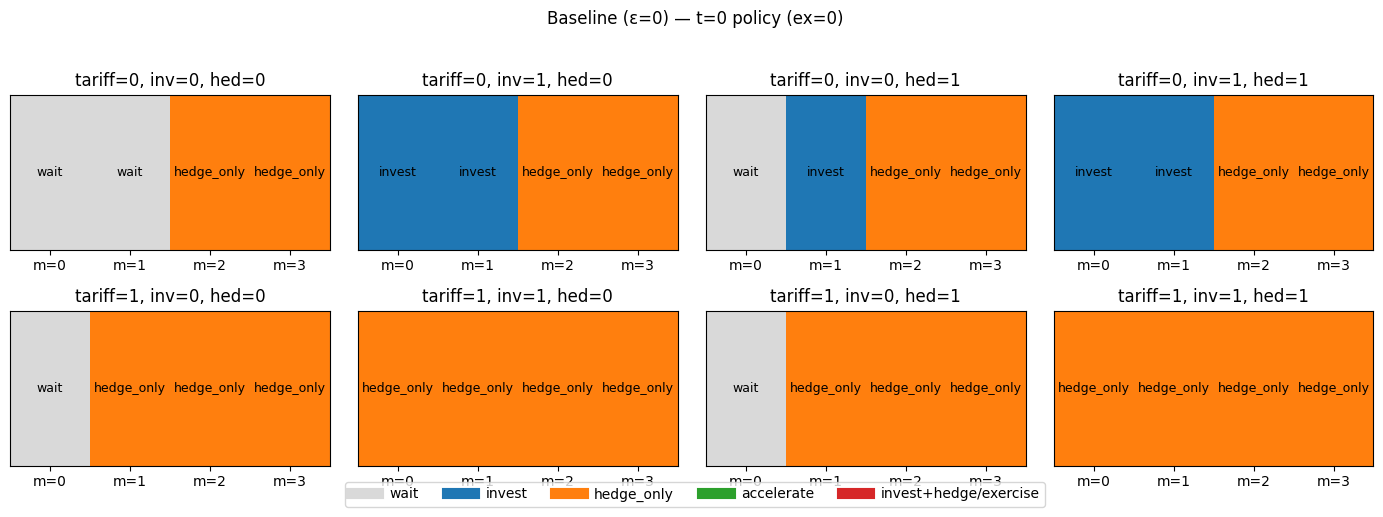

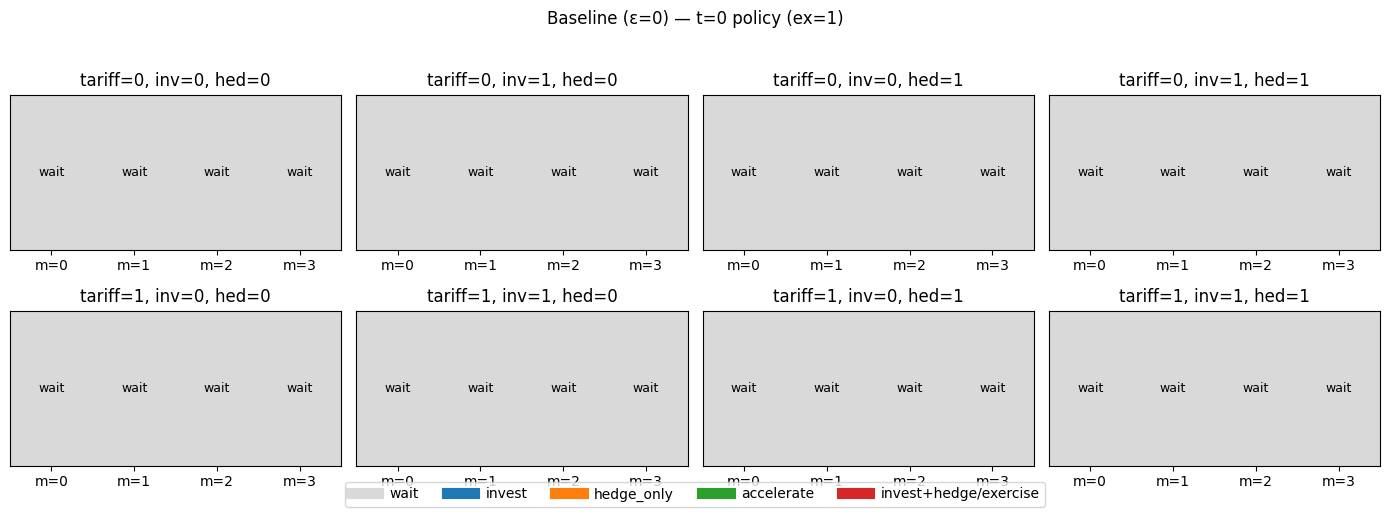

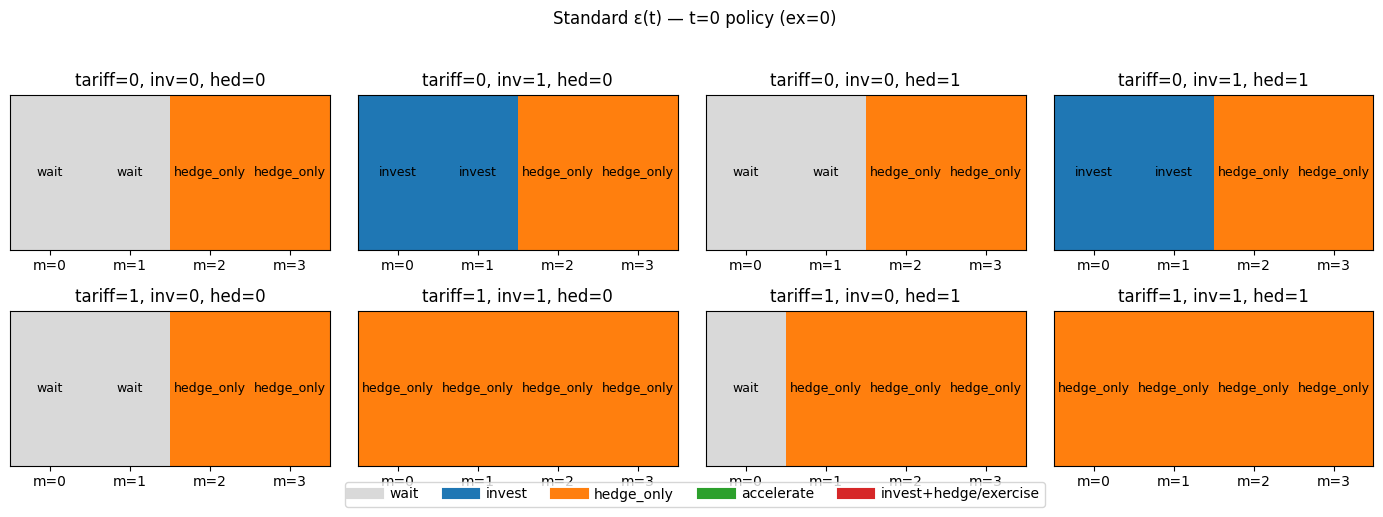

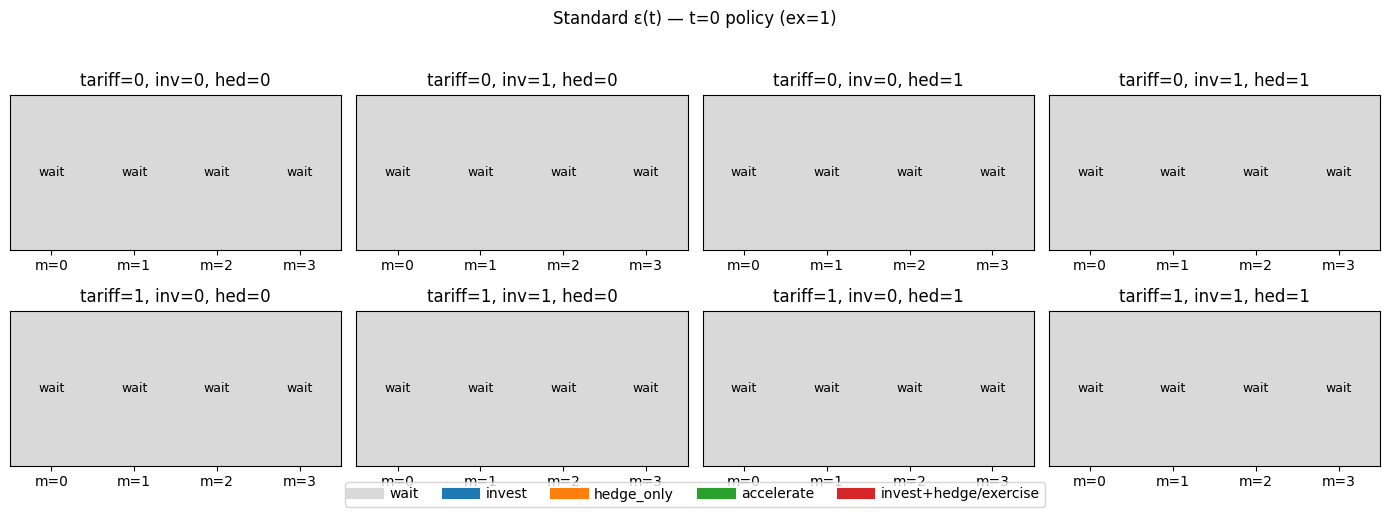

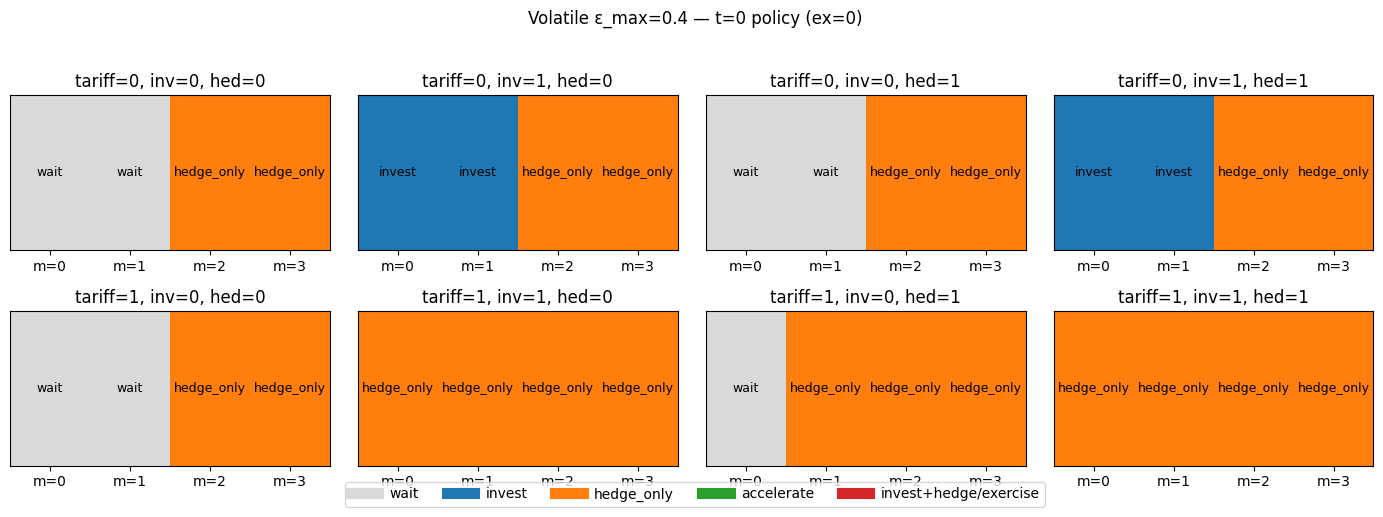

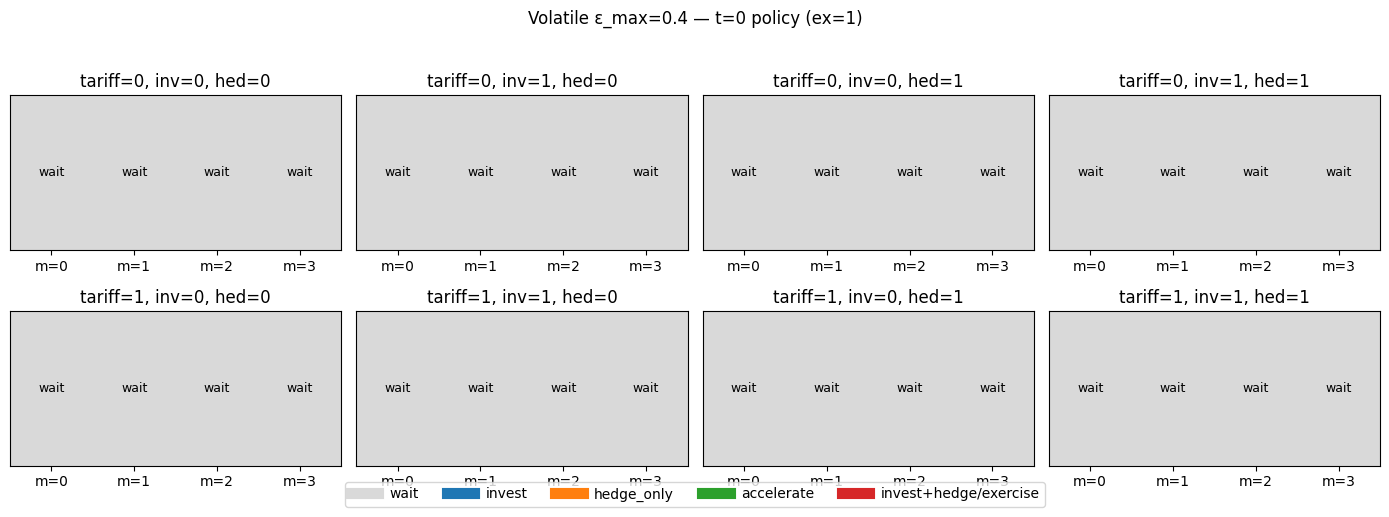

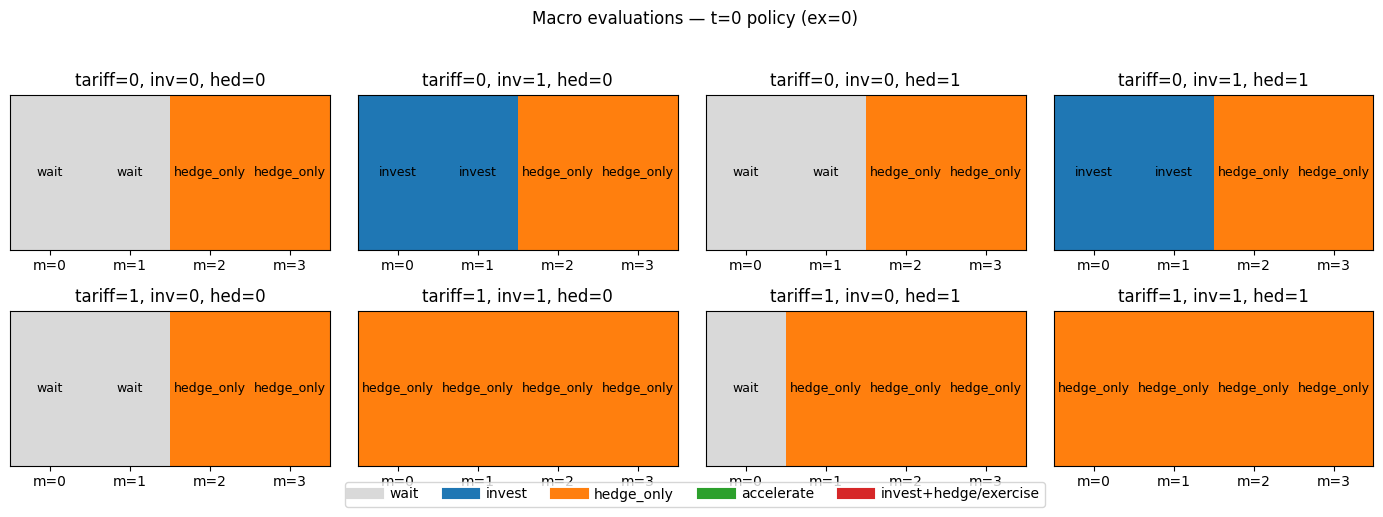

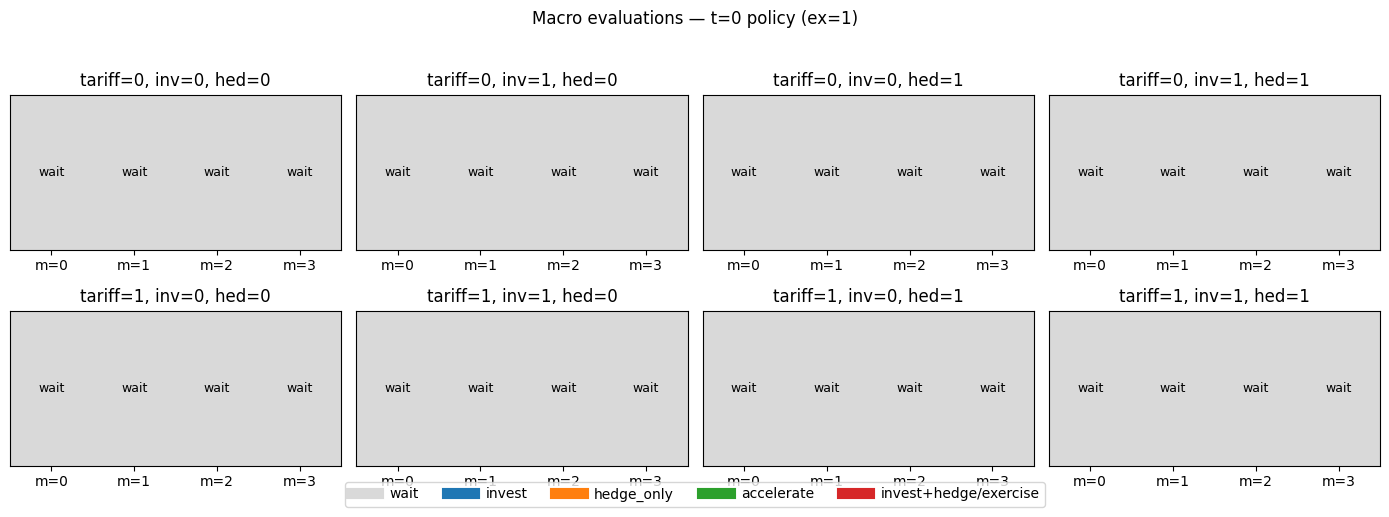

In [ ]:
# Diagnostics: policy maps (faceted) at t=0
# Facets: ex ∈ {0,1} as separate figures; within each figure: rows=tariff (0/1), cols=(inv,hed) combinations.

import matplotlib.colors as mcolors

ACTION_NAMES_DIAG = [
    "wait",
    "invest",
    "hedge_only",
    "accelerate_migration",
    "invest+hedge/exercise",
]

def policy_df_at_t(pi: np.ndarray, t: int = 0) -> pd.DataFrame:
    rows = []
    for s in range(N_STATES):
        tariff, m, inv, hed, ex = decode_state(s)
        rows.append(
            {
                "s": s,
                "t": t,
                "tariff": tariff,
                "m": m,
                "inv": inv,
                "hed": hed,
                "ex": ex,
                "a": int(pi[t, s]),
                "a_name": ACTION_NAMES_DIAG[int(pi[t, s])],
            }
        )
    return pd.DataFrame(rows)


def plot_policy_facets(df: pd.DataFrame, title: str):
    # Color map for actions (5 actions)
    cmap = mcolors.ListedColormap(["#d9d9d9", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
    norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], ncolors=5)

    inv_hed_cols = [(0, 0), (1, 0), (0, 1), (1, 1)]

    for ex_val in (0, 1):
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 4.8), sharey=True)
        fig.suptitle(f"{title} — t=0 policy (ex={ex_val})", y=1.03)

        for r, tariff_val in enumerate((0, 1)):
            for c, (inv_val, hed_val) in enumerate(inv_hed_cols):
                ax = axes[r, c]
                sub = df[(df.ex == ex_val) & (df.tariff == tariff_val) & (df.inv == inv_val) & (df.hed == hed_val)]
                # m runs 0..3; we display a 1x4 heatmap
                a_by_m = np.full((1, 4), np.nan)
                for m_val in range(4):
                    a = sub[sub.m == m_val].a.values
                    if len(a) == 1:
                        a_by_m[0, m_val] = a[0]

                ax.imshow(a_by_m, cmap=cmap, norm=norm, aspect="auto")
                ax.set_xticks(range(4))
                ax.set_xticklabels(["m=0", "m=1", "m=2", "m=3"], rotation=0)
                ax.set_yticks([])

                ax.set_title(f"tariff={tariff_val}, inv={inv_val}, hed={hed_val}")

                # annotate action names
                for m_val in range(4):
                    if not np.isnan(a_by_m[0, m_val]):
                        a_int = int(a_by_m[0, m_val])
                        ax.text(m_val, 0, ACTION_NAMES_DIAG[a_int], ha="center", va="center", fontsize=9)

        # legend
        handles = [
            plt.Line2D([0], [0], color=cmap(0), lw=8, label="wait"),
            plt.Line2D([0], [0], color=cmap(1), lw=8, label="invest"),
            plt.Line2D([0], [0], color=cmap(2), lw=8, label="hedge_only"),
            plt.Line2D([0], [0], color=cmap(3), lw=8, label="accelerate"),
            plt.Line2D([0], [0], color=cmap(4), lw=8, label="invest+hedge/exercise"),
        ]
        fig.legend(handles=handles, loc="lower center", ncol=5, bbox_to_anchor=(0.5, -0.02))
        plt.tight_layout()
        plt.show()


_required = ["pi_base", "pi_scn", "pi_vol", "pi_macro"]
_missing = [k for k in _required if k not in globals()]
if _missing:
    print("Run Section 9 (DP runs) first; missing:", _missing)
else:
    # Build and plot policy maps for each scenario (t=0)
    for name, pi in [
        ("Baseline (ε=0)", pi_base),
        ("Standard ε(t)", pi_scn),
        ("Volatile ε_max=0.4", pi_vol),
        ("Macro evaluations", pi_macro),
    ]:
        df0 = policy_df_at_t(pi, t=0)
        plot_policy_facets(df0, title=name)



### CFO interpretation of results

**What we did.** We compared four settings: a baseline with no ambiguity on political/regulatory risk, and three cases where we explicitly allow for ambiguity (uncertainty about how bad things can get). In all of them we optimized for **worst-case** value (CVaR 90%) of project NPV over a **10-year horizon**. The model has **five actions**: wait, invest, hedge only, accelerate migration, and invest+hedge/exercise-if-ready.

**Bottom line.** Check the **Review** table and the **Diagnostics** (tariff=1 start state) for the optimal initial action at t=0. If it is "wait" in all cases, the option is expensive/slow relative to risk over this horizon; if it switches when tariff is already ON or when horizon/tariff persistence are stressed (see **Sensitivity**), the policy is state- and scenario-dependent.

**What the table means.**

- **$V_0$** = worst-case NPV from the optimal policy, starting from today's state: $V(0,s_0)$. Same units as the objective (e.g. NPV cash).
- **Cost vs baseline** = $V_0(\varepsilon(\cdot)) - V_0(0)$: how much worse the worst-case outcome is once we introduce ambiguity. A positive number means we "lose" that much in worst-case terms.

So the **sovereignty premium** is the **cost of uncertainty**: the drop in worst-case value when we take political/regulatory ambiguity seriously (Wasserstein ball $\varepsilon(t)$).

**Reading the scenarios.**

- **Baseline (no ambiguity):** Reference. No extra penalty for uncertainty.
- **Standard eps(t):** Time-varying ambiguity. The premium is the cost of that uncertainty in worst-case NPV.
- **Volatile (eps_max=0.4):** Stronger ambiguity. A larger premium means a bigger hit to worst-case value if we assume a more volatile risk environment.
- **Macro evaluations:** Risk and ambiguity peaked in specific years (e.g. year 1 and 3). The premium shows how much worst-case value is affected when we concentrate uncertainty there.

**Using the diagnostics (run after Section 9).**
- **Tariff=1 start state:** Does the optimal a0 change when the shock is already on? If it still waits, mitigation is priced high or slow.
- **Policy maps (faceted):** Action by (tariff, m, inv, hed, ex) shows when the model invests, hedges, or exercises.
- **Break-even bound:** Back-of-envelope check on whether exit can ever pay; helps interpret "wait" vs "act".
- **Sensitivity (horizon x tariff persistence):** Shows when the initial action flips as we extend horizon or change tariff probabilities.

**Implications for the CFO.**

1. **Capital and timing:** Use the recommended a0 and the sensitivity table to decide when to revisit (e.g. tariff or regulatory clarity).
2. **Budgeting:** Use the **sovereignty premium** (and “Cost vs baseline”) as a **reserve or stress buffer**: in worst-case terms, ambiguity “costs” roughly that much NPV. It can inform contingency or scenario planning.
3. **Scenario comparison:** If the premium is much higher in the volatile or macro case, that signals sensitivity to how we model uncertainty. Sensitivity analysis and stress tests around those scenarios are warranted.
4. **Policies, not just numbers:** The same “wait” recommendation with different premiums means the **cost of that stance** varies by scenario. Communicating both the recommended action and the associated worst-case cost helps align board and management on risk tolerance.

### Review: Wait (do nothing) — at what cost?

In all scenarios the optimal initial action is **wait** (do nothing). The table below shows the **cost of that stance**: how much worst-case NPV changes when we account for ambiguity (sovereignty premium), and the implied cost of staying in "wait" under each environment.

In [ ]:
ACTION_NAMES = [
    "wait (do nothing)",
    "invest",
    "hedge_only",
    "accelerate_migration",
    "invest+hedge/exercise",
]

review = pd.DataFrame([
    {"Scenario": "Baseline (no ambiguity)", "Optimal a0": ACTION_NAMES[int(pi_base[0, s0])], "V0": V0_base, "Cost vs baseline": 0.0},
    {"Scenario": "Standard eps(t)", "Optimal a0": ACTION_NAMES[int(pi_scn[0, s0])], "V0": V0_scn, "Cost vs baseline": -premium},
    {"Scenario": "Volatile eps_max=0.4", "Optimal a0": ACTION_NAMES[int(pi_vol[0, s0])], "V0": V0_vol, "Cost vs baseline": -premium_volatile},
    {"Scenario": "Macro evaluations", "Optimal a0": ACTION_NAMES[int(pi_macro[0, s0])], "V0": V0_macro, "Cost vs baseline": -premium_macro},
])
print("Optimal action at t=0:", ACTION_NAMES[int(pi_base[0, s0])])
print("Cost of wait under ambiguity = drop in worst-case NPV vs baseline (positive = we lose that much).")
review

Optimal action at t=0: wait (do nothing)
Cost of wait under ambiguity = drop in worst-case NPV vs baseline (positive = we lose that much).


,Scenario,Optimal a0,V0,Cost vs baseline
0,Baseline (no ambiguity),wait (do nothing),36.372325,0.000000
1,Standard eps(t),wait (do nothing),40.435842,-4.063517
2,Volatile eps_max=0.4,wait (do nothing),41.763630,-5.391305
3,Macro evaluations,wait (do nothing),38.693873,-2.321548


In [ ]:
# Quick break-even sanity bounds (back-of-envelope)
# These are NOT the DP objective; they help interpret why "wait" can dominate.

exit_total = spec.termination_fee + spec.cutover_cost + spec.recert_audit_cost
capex_total = spec.capex_invest
upfront_nohedge = capex_total + exit_total
upfront_withhedge = capex_total + spec.capex_hedge_setup + exit_total

per_period_savings_if_tariff_on = spec.tariff_cost - spec.post_exit_cost

# Conservative assumption: earliest exit payoff starts at t = exit_years (after full progress)
# (This is a CFO-friendly bound, not a precise policy simulation.)
start_savings_t = spec.exit_years
pv_max_savings = 0.0
for t in range(start_savings_t, spec.horizon):
    pv_max_savings += discount_factor(spec, t) * per_period_savings_if_tariff_on

print("=== Break-even sanity bounds (worst-case style intuition) ===")
print(f"Exit one-off total (termination+cutover+recert): {exit_total:.2f}")
print(f"Upfront (capex_invest + exit): {upfront_nohedge:.2f}")
print(f"Upfront incl. hedge setup (capex_invest + capex_hedge_setup + exit): {upfront_withhedge:.2f}")
print(f"Per-period savings after exit if tariff=1 (tariff_cost - post_exit_cost): {per_period_savings_if_tariff_on:.2f}")
print(f"Max discounted savings window if tariff stays ON after exit (t≥{start_savings_t}): {pv_max_savings:.2f}")

if pv_max_savings > 0:
    print(f"Break-even (no hedge) requires tariff-on persistence/probability scaling ≳ {upfront_nohedge/pv_max_savings:.2f}× of the max-savings case")
    print(f"Break-even (with hedge setup) requires scaling ≳ {upfront_withhedge/pv_max_savings:.2f}× of the max-savings case")
print("Interpretation: if even the *max* discounted savings window is not much larger than upfront costs, the DP will rationally prefer waiting.")

=== Break-even sanity bounds (worst-case style intuition) ===
Exit one-off total (termination+cutover+recert): 19.00
Upfront (capex_invest + exit): 27.00
Upfront incl. hedge setup (capex_invest + capex_hedge_setup + exit): 29.00
Per-period savings after exit if tariff=1 (tariff_cost - post_exit_cost): 9.00
Max discounted savings window if tariff stays ON after exit (t≥3): 36.21
Break-even (no hedge) requires tariff-on persistence/probability scaling ≳ 0.75× of the max-savings case
Break-even (with hedge setup) requires scaling ≳ 0.80× of the max-savings case
Interpretation: if even the *max* discounted savings window is not much larger than upfront costs, the DP will rationally prefer waiting.


## 10) Sensitivity: horizon and tariff-chain stress tests (ε=0 fast path)

This section stress-tests the **nominal tariff Markov chain** and **horizon length** to see when the optimal initial action changes.

- We run **$\varepsilon = 0$** (no ambiguity) to isolate the effect of persistence/probability vs. cost structure.
- We report $a_0$ for **two start states**: $\mathrm{tariff}=0$ and $\mathrm{tariff}=1$ (both at $m=0$, $\mathrm{inv}=0$, $\mathrm{hed}=0$, $\mathrm{ex}=0$).

In [ ]:
# Sensitivity loop: vary horizon and tariff persistence, compute a0 at tariff=0 and tariff=1 start states.

ACTION_NAMES_SENS = [
    "wait",
    "invest",
    "hedge_only",
    "accelerate_migration",
    "invest+hedge/exercise",
]

s_start_tariff0 = encode_state(tariff=0, m=0, inv=0, hed=0, ex=0)
s_start_tariff1 = encode_state(tariff=1, m=0, inv=0, hed=0, ex=0)

horizons = [6, 10, 12]
p01_list = [0.10, 0.15, 0.25]
p10_list = [0.05, 0.10, 0.20]

rows = []
for H in horizons:
    for p01 in p01_list:
        for p10 in p10_list:
            spec2 = spec.model_copy(update={"horizon": H, "tariff_p01": p01, "tariff_p10": p10})
            V2, pi2 = dp_solve_cfo(spec2, C, eps_fn=lambda t, h: 0.0, log_lp_timing=False)

            a0_0 = int(pi2[0, s_start_tariff0])
            a0_1 = int(pi2[0, s_start_tariff1])

            rows.append(
                {
                    "horizon": H,
                    "p01": p01,
                    "p10": p10,
                    "a0(tariff=0)": ACTION_NAMES_SENS[a0_0],
                    "a0(tariff=1)": ACTION_NAMES_SENS[a0_1],
                    "V0(tariff=0)": float(V2[0, s_start_tariff0]),
                    "V0(tariff=1)": float(V2[0, s_start_tariff1]),
                }
            )

sens = pd.DataFrame(rows)

# Display a compact view first
cols = ["horizon", "p01", "p10", "a0(tariff=0)", "a0(tariff=1)", "V0(tariff=0)", "V0(tariff=1)"]
sens[cols].sort_values(["horizon", "p01", "p10"]).reset_index(drop=True)

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/384 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/640 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

DP (t, s):   0%|          | 0/768 [00:00<?, ?state/s]

,horizon,p01,p10,a0(tariff=0),a0(tariff=1),V0(tariff=0),V0(tariff=1)
0,6,0.10,0.05,wait,hedge_only,24.562902,30.744721
1,6,0.10,0.10,wait,hedge_only,24.562902,30.744721
2,6,0.10,0.20,wait,hedge_only,24.562902,30.744721
3,6,0.15,0.05,wait,hedge_only,24.562902,30.744721
4,6,0.15,0.10,wait,hedge_only,24.562902,30.744721
5,6,0.15,0.20,wait,hedge_only,24.562902,30.744721
6,6,0.25,0.05,wait,hedge_only,24.562902,30.744721
7,6,0.25,0.10,wait,hedge_only,24.562902,30.744721
8,6,0.25,0.20,wait,hedge_only,24.562902,30.744721
9,10,0.10,0.05,wait,hedge_only,36.372325,42.554143


## 11) Slide-like outputs
### Slide A — Risk environment $R(t)$, $\varepsilon(t)$

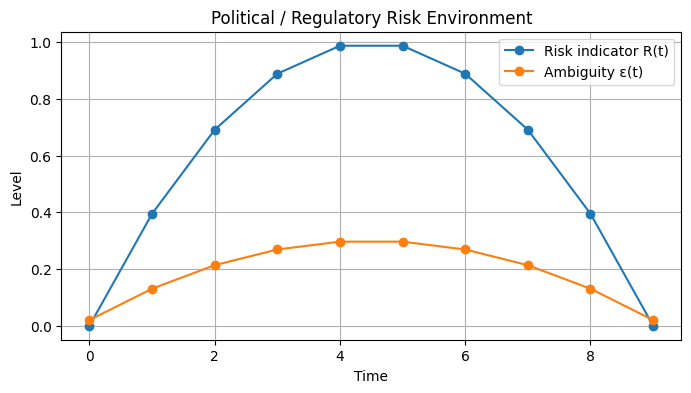

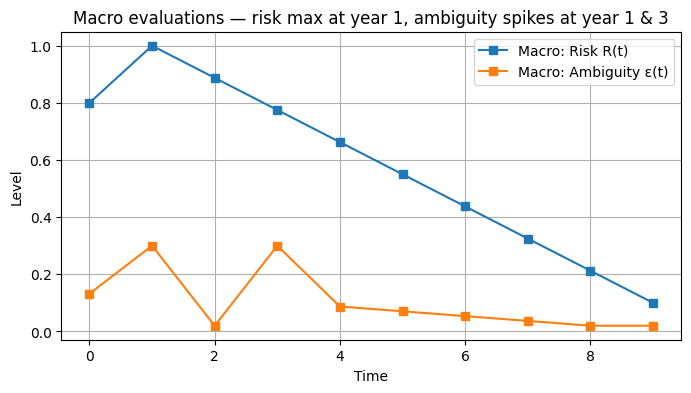

In [ ]:
eps_vals = [eps_schedule_indicator(t, spec.horizon) for t in range(spec.horizon)]
R_vals = [risk_indicator(t, spec.horizon) for t in range(spec.horizon)]
R_macro = [risk_indicator_macro(t, spec.horizon) for t in range(spec.horizon)]
eps_macro = [eps_schedule_macro(t, spec.horizon) for t in range(spec.horizon)]

plt.figure(figsize=(8,4))
plt.plot(range(spec.horizon), R_vals, marker="o", label="Risk indicator R(t)")
plt.plot(range(spec.horizon), eps_vals, marker="o", label="Ambiguity ε(t)")
plt.title("Political / Regulatory Risk Environment")
plt.xlabel("Time")
plt.ylabel("Level")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(range(spec.horizon), R_macro, marker="s", label="Macro: Risk R(t)")
plt.plot(range(spec.horizon), eps_macro, marker="s", label="Macro: Ambiguity ε(t)")
plt.title("Macro evaluations — risk max at year 1, ambiguity spikes at year 1 & 3")
plt.xlabel("Time")
plt.ylabel("Level")
plt.grid(True)
plt.legend()
plt.show()

### Slide B — Robust NPV impact (baseline vs $\varepsilon(t)$)

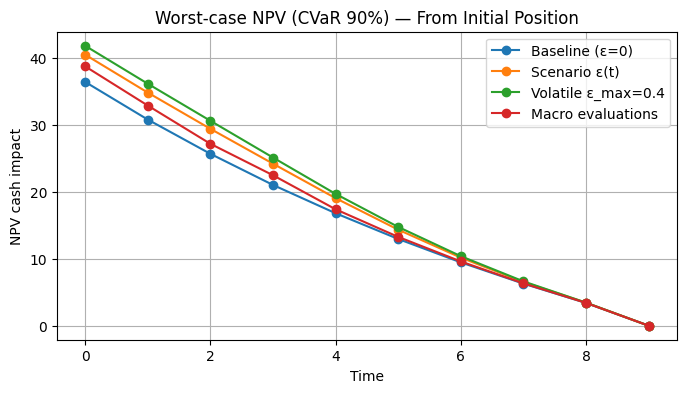

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(range(spec.horizon), V_base[:-1, s0], marker="o", label="Baseline (ε=0)")
plt.plot(range(spec.horizon), V_scn[:-1, s0], marker="o", label="Scenario ε(t)")
plt.plot(range(spec.horizon), V_vol[:-1, s0], marker="o", label="Volatile ε_max=0.4")
plt.plot(range(spec.horizon), V_macro[:-1, s0], marker="o", label="Macro evaluations")
plt.title("Worst-case NPV (CVaR 90%) — From Initial Position")
plt.xlabel("Time")
plt.ylabel("NPV cash impact")
plt.grid(True)
plt.legend()
plt.show()

### Slide C — Sovereignty premium

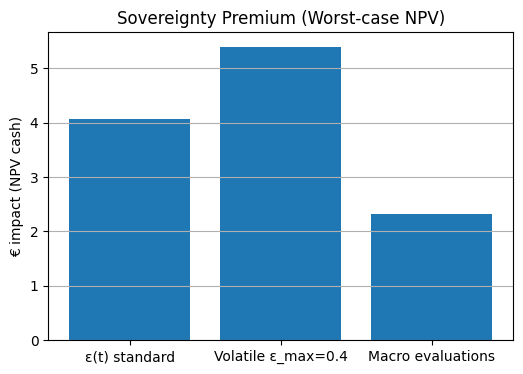

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(["ε(t) standard", "Volatile ε_max=0.4", "Macro evaluations"], [premium, premium_volatile, premium_macro])
plt.title("Sovereignty Premium (Worst-case NPV)")
plt.ylabel("€ impact (NPV cash)")
plt.grid(True, axis="y")
plt.show()

### Slide D — Rollout (mode nominal) to explain the policy

We follow the most likely next state under the nominal transition (for illustration).

In [ ]:
def rollout_policy_mode(spec: GameSpec, pi, start_state: int):
    s = start_state
    out = []
    for t in range(spec.horizon):
        a = int(pi[t, s])
        cash, ebitda, ebit = stage_losses_cfo(spec, s, a)
        p0 = build_p0_over_full_state(spec, s, a)
        sp = int(np.argmax(p0))  # nominal mode
        out.append((t, s, a, cash, ebitda, ebit, sp))
        s = sp
    return out

roll = rollout_policy_mode(spec, pi_scn, s0)

rows = []
for t, s, a, cash, ebitda, ebit, sp in roll:
    tariff, m, inv, hed, ex = decode_state(s)
    tariff2, m2, inv2, hed2, ex2 = decode_state(sp)
    rows.append({
        "t": t,
        "state": f"tariff={tariff}, m={m}, inv={inv}, hed={hed}, ex={ex}",
        "action": ["wait","invest","invest+hedge/exercise"][a],
        "cash": cash,
        "disc": discount_factor(spec, t),
        "next_state(mode)": f"tariff={tariff2}, m={m2}, inv={inv2}, hed={hed2}, ex={ex2}",
    })

pd.DataFrame(rows)

,t,state,action,cash,disc,next_state(mode)
0,0,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,1.000000,"tariff=0, m=0, inv=0, hed=0, ex=0"
1,1,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.909091,"tariff=0, m=0, inv=0, hed=0, ex=0"
2,2,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.826446,"tariff=0, m=0, inv=0, hed=0, ex=0"
3,3,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.751315,"tariff=0, m=0, inv=0, hed=0, ex=0"
4,4,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.683013,"tariff=0, m=0, inv=0, hed=0, ex=0"
5,5,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.620921,"tariff=0, m=0, inv=0, hed=0, ex=0"
6,6,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.564474,"tariff=0, m=0, inv=0, hed=0, ex=0"
7,7,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.513158,"tariff=0, m=0, inv=0, hed=0, ex=0"
8,8,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.466507,"tariff=0, m=0, inv=0, hed=0, ex=0"
9,9,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.424098,"tariff=0, m=0, inv=0, hed=0, ex=0"


In [ ]:
# Rollout (mode nominal) — updated action names for the extended action set

ACTION_NAMES = [
    "wait",
    "invest",
    "hedge_only",
    "accelerate_migration",
    "invest+hedge/exercise",
]

roll = rollout_policy_mode(spec, pi_scn, s0)

rows = []
for t, s, a, cash, ebitda, ebit, sp in roll:
    tariff, m, inv, hed, ex = decode_state(s)
    tariff2, m2, inv2, hed2, ex2 = decode_state(sp)
    rows.append({
        "t": t,
        "state": f"tariff={tariff}, m={m}, inv={inv}, hed={hed}, ex={ex}",
        "action": ACTION_NAMES[a],
        "cash": cash,
        "disc": discount_factor(spec, t),
        "next_state(mode)": f"tariff={tariff2}, m={m2}, inv={inv2}, hed={hed2}, ex={ex2}",
    })

pd.DataFrame(rows)

,t,state,action,cash,disc,next_state(mode)
0,0,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,1.000000,"tariff=0, m=0, inv=0, hed=0, ex=0"
1,1,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.909091,"tariff=0, m=0, inv=0, hed=0, ex=0"
2,2,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.826446,"tariff=0, m=0, inv=0, hed=0, ex=0"
3,3,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.751315,"tariff=0, m=0, inv=0, hed=0, ex=0"
4,4,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.683013,"tariff=0, m=0, inv=0, hed=0, ex=0"
5,5,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.620921,"tariff=0, m=0, inv=0, hed=0, ex=0"
6,6,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.564474,"tariff=0, m=0, inv=0, hed=0, ex=0"
7,7,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.513158,"tariff=0, m=0, inv=0, hed=0, ex=0"
8,8,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.466507,"tariff=0, m=0, inv=0, hed=0, ex=0"
9,9,"tariff=0, m=0, inv=0, hed=0, ex=0",wait,0.0,0.424098,"tariff=0, m=0, inv=0, hed=0, ex=0"
